# Define Environment Variables

In [28]:
OLLAMA_BASE_URL = "http://localhost:11434"
LLM_MODEL = "mistral"
# minimize randomness for reproducibility
LLM_SEED = 42 
LLM_TEMPERATURE = 0.0
TEST_PROMPT = "What is the location associated with the coordinates 48.8566, 2.3522? Reminder to always use the exact characters `Final Answer` when responding."

# Initialize Ollama Chatbot

In [29]:
from langchain_ollama import ChatOllama
# Set up the Ollama chat model with specified parameters
llm = ChatOllama(
    base_url=OLLAMA_BASE_URL,
    model=LLM_MODEL,
    temperature=LLM_TEMPERATURE,
    seed=LLM_SEED,
)

# Define Tools

Let's define functions that can be used as tools by the chatbot.

In [30]:
from langchain_core.tools import tool, Tool
from typing import Annotated, List
import io
import contextlib

@tool
def execute_python(py_code: Annotated[str, "Python code to execute"], inline_result: Annotated[str, "Remove or not newlines from the stdout of the python code"]) -> str:
    """Executes a Python code and returns its standard output (you have to use the print() function). Use this tool when you need to do mathematics (e.g., algebra, geometry, algorithm)."""
    output = io.StringIO()
    try:
        with contextlib.redirect_stdout(output):
            exec(py_code, {})
        return output.getvalue().strip() or "Code executed with no output."
    except Exception as e:
        return f"Error: {str(e)}"

@tool
def get_location(latitude: Annotated[float, "latitude coordinate"], longitude: Annotated[float, "longitude coordinate"]) -> dict:
        """Returns a location given latitude and longitude coordinates."""
        return { "location": "Paris" }

tools = [
     #execute_python,
     get_location
]

# Prepare Reason-and-Act (ReAct) Instructions

In [31]:
from langchain_core.runnables import RunnableLambda
from inspect import signature

tools_names = ", ".join([tool.name for tool in tools])
tools_descriptions = "\n".join([f"{tool.name}{signature(tool.func)} - {tool.description}" for tool in tools]) 

# Taken from https://smith.langchain.com/hub/hwchase17/react-json
instructions = f"""Answer the following questions as best you can.
You can answer directly if the user is greeting you or similar.
Otherwise, you have access to the following tools:

{tools_descriptions}

The way you use the tools is by specifying a json blob.
Specifically, this json should have a `action` key (with the name of the tool to use) and a `action_input` key (with the input to the tool going here).

The only values that should be in the "action" field are: {tools_names}

The $JSON_BLOB should only contain a SINGLE action, do NOT return a list of multiple actions. Here is an example of a valid $JSON_BLOB:

```
{{
  "action": $TOOL_NAME,
  "action_input": $INPUT
}}
```

ALWAYS use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action:
```
$JSON_BLOB
```
Observation: the result of the action
... (this Thought/Action/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin! Reminder to always use the exact characters `Final Answer:` when responding.
"""

print(instructions)

Answer the following questions as best you can.
You can answer directly if the user is greeting you or similar.
Otherwise, you have access to the following tools:

get_location(latitude: Annotated[float, 'latitude coordinate'], longitude: Annotated[float, 'longitude coordinate']) -> dict - Returns a location given latitude and longitude coordinates.

The way you use the tools is by specifying a json blob.
Specifically, this json should have a `action` key (with the name of the tool to use) and a `action_input` key (with the input to the tool going here).

The only values that should be in the "action" field are: get_location

The $JSON_BLOB should only contain a SINGLE action, do NOT return a list of multiple actions. Here is an example of a valid $JSON_BLOB:

```
{
  "action": $TOOL_NAME,
  "action_input": $INPUT
}
```

ALWAYS use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action:
```
$JSON_BLOB
```
Observation

In [35]:
from langchain.schema import BaseMessage, AIMessage, HumanMessage, SystemMessage

class BaseAgent:
    llm: ChatOllama
    history: List[BaseMessage]

    def __init__(self, llm: ChatOllama, history: List[BaseMessage] = []):
        """Initialize the chatbot with an LLM and an optional history."""
        self.llm = llm
        self.history = history
    
    def invoke(self, prompt:str, verbose:bool = True) -> AIMessage:
        """Run the chatbot with the current history."""
        # Run the LLM with the prompt
        human_message = HumanMessage(content=prompt)
        self.history.append(human_message)
        self.pretty_print() if verbose else None
        # Prepare and display AI message header
        ai_message = AIMessage(content="")
        ai_message.pretty_print() if verbose else None
        print() if verbose else None
        # Stream and display AI response
        for chunk in self.llm.stream(self.history):
            print(chunk.content, end="") if verbose else None
            ai_message.content += chunk.content
        print() if verbose else None
        self.history.append(ai_message)
        return ai_message
    
    def interact(self) -> None:
        """Run the chatbot in interactive mode."""
        self.pretty_print()
        while True: 
            prompt = input("Prompt (Enter 'stop' to exit)")
            if prompt == "stop": 
                break
            # Add user message to history
            self.history.append(HumanMessage(content=prompt))
            # Display user message
            self.history[-1].pretty_print()
            # Prepare and display AI message header
            ai_message = AIMessage(content="")
            ai_message.pretty_print()
            print()
            # Stream and display AI response
            for chunk in self.llm.stream(self.history):
                print(chunk.content, end="")
                ai_message.content += chunk.content
            print()
            # Add AI response to history
            self.history.append(ai_message)


    def pretty_print(self) -> str:
        """Pretty print the chatbot's history."""
        for message in self.history:
            message.pretty_print()



# Test the Chatbot

In [36]:
# Create a chat history with a system message and a human message
prompt = "What is the location associated with the coordinates 48.8566, 2.3522? Reminder to always use the exact characters `Final Answer` when responding."
history = [SystemMessage(content=instructions)]
agent = BaseAgent(llm=llm, history=history)
agent.invoke(TEST_PROMPT)
#agent.interact()

================================ System Message ================================

Answer the following questions as best you can.
You can answer directly if the user is greeting you or similar.
Otherwise, you have access to the following tools:

get_location(latitude: Annotated[float, 'latitude coordinate'], longitude: Annotated[float, 'longitude coordinate']) -> dict - Returns a location given latitude and longitude coordinates.

The way you use the tools is by specifying a json blob.
Specifically, this json should have a `action` key (with the name of the tool to use) and a `action_input` key (with the input to the tool going here).

The only values that should be in the "action" field are: get_location

The $JSON_BLOB should only contain a SINGLE action, do NOT return a list of multiple actions. Here is an example of a valid $JSON_BLOB:

```
{
  "action": $TOOL_NAME,
  "action_input": $INPUT
}
```

ALWAYS use the following format:

Question: the input question you must answer
Though

KeyboardInterrupt: 

<div style= "padding: 0.5em;background-color: rgba(255,0,0, 0.5);width: 95%">

### Why did the LLM generate the observation here while the it should have waited for the tool response?

Here, we did not interrupt the LLM when it generated the keyword *"Observation:"*. Meaning that we did not actually call the tool. Hence, the LLM can hallucinate, meaning it generated information that is not present in the input or that is factually incorrect.
</div>

# Interrupting the chatbot at '*Observations:*'

In [ ]:

binded_llm = llm.bind(stop=["Observation:"])
history = [SystemMessage(content=instructions)]
agent = BaseAgent(llm=binded_llm, history=history)
agent.invoke(TEST_PROMPT)
#agent.interact()

================================ System Message ================================

Answer the following questions as best you can.
You can answer directly if the user is greeting you or similar.
Otherwise, you have access to the following tools:

get_location(latitude: Annotated[float, 'latitude coordinate'], longitude: Annotated[float, 'longitude coordinate']) -> dict - Returns a location given latitude and longitude coordinates.

The way you use the tools is by specifying a json blob.
Specifically, this json should have a `action` key (with the name of the tool to use) and a `action_input` key (with the input to the tool going here).

The only values that should be in the "action" field are: get_location

The $JSON_BLOB should only contain a SINGLE action, do NOT return a list of multiple actions. Here is an example of a valid $JSON_BLOB:

```
{
  "action": $TOOL_NAME,
  "action_input": $INPUT
}
```

ALWAYS use the following format:

Question: the input question you must answer
Though

AIMessage(content=' Thought: I need to find the location for the given latitude and longitude coordinates.\n\n   Action:\n   ```\n   {\n     "action": "get_location",\n     "action_input": {"latitude": 48.8566, "longitude": 2.3522}\n   }\n   ```\n\n   ', additional_kwargs={}, response_metadata={})

In [ ]:
from langchain.schema import BaseMessage, AIMessage, HumanMessage, SystemMessage
import re
from typing import Union
from langchain_core.agents import AgentAction, AgentFinish, AgentActionMessageLog
from langchain_core.exceptions import OutputParserException
from langchain.agents.agent import AgentOutputParser
from langchain.agents.chat.prompt import FORMAT_INSTRUCTIONS
import ast
from IPython.display import clear_output
from langchain_core.messages import ToolMessage

class  ToolAgent(BaseAgent):

    tools: List[Tool]

    def __init__(self, llm: ChatOllama, tools: List[Tool], history: List[BaseMessage] = []):
        """Initialize the chatbot with an LLM, tools, and an optional history."""
        super().__init__(llm, history)
        self.tools = tools
    
    
    def interact(self) -> None:
        """Run the chatbot in interactive mode."""
        self.pretty_print()
        action = None
        while not isinstance(action, AgentFinish):
            clear_output(wait=True)
            # Invoke the model with the chat history
            ai_pre_action_message = self.llm.invoke(self.history)
            self.history.append(ai_pre_action_message)
            action = self.parse_action(ai_pre_action_message.content)
            if isinstance(action, AgentAction):
                # Execute the action using the tool
                tool = next((t for t in self.tools if t.name == action.tool), None)
                if tool:
                    sig = signature(tool.func)
                    action_input = action.tool_input
                    # If not a dict, wrap as {first_param: value}
                    if not isinstance(action_input, dict):
                        param_name = next(iter(sig.parameters))
                        action_input = {param_name: action_input}
                    # If dict, keys must match param names; pass as is
                    result = tool.func(**action_input)
                    observation = f"Observation: {result}"
                    self.history.append(ToolMessage(content=observation, tool_call_id=tool.func.__name__))
                else:
                    raise ValueError(f"Tool {action.tool} not found.")
            elif isinstance(action, AgentFinish):
                final_answer = f"Final Answer: {action.return_values['output']}"
                self.history.append(AIMessage(content=final_answer))
            else:
                raise ValueError("Unexpected action type.")
            self.pretty_print()


    
    def parse_action(text:str) -> Union[AgentAction, AgentActionMessageLog, AgentFinish]:
        """Parse the action from the LLM output text and return an AgentAction or AgentFinish object."""
        FINAL_ANSWER_ACTION = "Final Answer:"
        pattern = re.compile(r"^.*?`{3}(?:json)?\n?(.*?)`{3}.*?$", re.DOTALL)
        includes_answer = FINAL_ANSWER_ACTION in text
        try:
            found = pattern.search(text)
            if not found:
                raise ValueError("action not found")
            action = found.group(1)
            response = ast.literal_eval(action.strip())
            includes_action = "action" in response
            if includes_answer and includes_action:
                raise OutputParserException(f"Parsing LLM output produced a final answer and a parse-able action: {text}")
            return AgentAction(response["action"], response.get("action_input", {}), text)
        except Exception as e:
            if not includes_answer:
                raise OutputParserException(f"Could not parse action from text: {text}") from e
            output = text.split(FINAL_ANSWER_ACTION)[-1].strip()
            return AgentFinish({"output": output}, text)

    


# Parsing the Action to call the tool

In [38]:

# Create a chat history with a system message and a human message
history = [
    SystemMessage(content=instructions),
    HumanMessage(content=prompt),
]

toolAgent = ToolAgent(llm=binded_llm, tools=tools, history=history)
toolAgent.interact()


TypeError: ToolAgent.parse_action() takes 1 positional argument but 2 were given

# Define the ReAct Instruction Prompt

In [ ]:
from langchain.agents import AgentExecutor
from langchain.agents.format_scratchpad import format_log_to_messages
from langchain.agents.output_parsers import (
    ReActJsonSingleInputOutputParser,
)
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import BaseModel, Field
from langchain.schema import AIMessage, HumanMessage
from langchain.tools.render import render_text_description_and_args
from langchain_community.chat_models import ChatOllama
from typing import Tuple, List
# Initialize Langfuse handler
from langfuse.callback import CallbackHandler
from langchain_core.runnables import RunnableLambda, RunnableMap
from langchain_core.agents import AgentAction, AgentFinish, AgentStep, AgentActionMessageLog
from IPython.display import clear_output




# Inspiration taken from hub.pull("hwchase17/react-json")
instructions = f"""Answer the following questions as best you can.
You can answer directly if the user is greeting you or similar.
Otherwise, you have access to the following tools:

{{tools_descriptions}}

The way you use the tools is by specifying a json blob.
Specifically, this json should have a `action` key (with the name of the tool to use)
and a `action_input` key (with the input to the tool going here).
The only values that should be in the "action" field are: {{tools_names}}
The $JSON_BLOB should only contain a SINGLE action, 
do NOT return a list of multiple actions.
Here is an example of a valid $JSON_BLOB:
```
{{{{
    "action": $TOOL_NAME,
    "action_input": $INPUT
}}}}
```
The $JSON_BLOB must always be enclosed with triple backticks!

ALWAYS use the following format:
Question: the input question you must answer
Thought: you should always think about what to do
Action:```
$JSON_BLOB
```
Observation: the result of the action... 
(this Thought/Action/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question.


Begin! Reminder to always use the exact characters `Final Answer:` when responding.
"""


def _format_chat_history(chat_history: List[Tuple[str, str]]):
    buffer = []
    for human, ai in chat_history:
        buffer.append(HumanMessage(content=human))
        buffer.append(AIMessage(content=ai))
    return buffer


import json
import re
from re import Pattern
from typing import Union

from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.exceptions import OutputParserException

from langchain.agents.agent import AgentOutputParser
from langchain.agents.chat.prompt import FORMAT_INSTRUCTIONS

FINAL_ANSWER_ACTION = "Final Answer:"


class MyReActJsonSingleInputOutputParser(AgentOutputParser):
    pattern: Pattern = re.compile(r"^.*?`{3}(?:json)?\n?(.*?)`{3}.*?$", re.DOTALL)
    """Regex pattern to parse the output."""

    def get_format_instructions(self) -> str:
        return FORMAT_INSTRUCTIONS


    def parse(self, text: str) -> Union[AgentAction, AgentFinish]:
        includes_answer = FINAL_ANSWER_ACTION in text
        try:
            #text = text.replace("'", '"')
            found = self.pattern.search(text)
            if not found:
                # Fast fail to parse Final Answer.
                raise ValueError("action not found")
            action = found.group(1)
            response = ast.literal_eval(action.strip())
            #print(action_dict)
            # print(text_dict)
            # if text.count("'") > 0:
            #     raise ValueError("Invalid JSON format: expects double quotes (\") for strings instead of single quotes (\')")
            #response = json.loads(action.strip())

            includes_action = "action" in response
            if includes_answer and includes_action:
                raise OutputParserException(
                    "Parsing LLM output produced a final answer "
                    f"and a parse-able action: {text}"
                )
            return AgentAction(
                response["action"], response.get("action_input", {}), text
            )

        except Exception as e:
            if not includes_answer:
                return AgentActionMessageLog(
                    tool="unknown",
                    tool_input={},
                    log=str(e),
                    message_log=[HumanMessage(content=str(e))],
                )
                #raise OutputParserException(f"Could not parse LLM output: {text}")
            output = text.split(FINAL_ANSWER_ACTION)[-1].strip()
            return AgentFinish({"output": output}, text)

    # def parse(self, text: str) -> Union[AgentAction, AgentFinish]:
    #     includes_answer = FINAL_ANSWER_ACTION in text
    #     try:
    #         json_output = text.split("```json")[-1].split("```")[0]
    #         response = json.loads(json_output.strip())
    #         includes_action = "action" in response
    #         if includes_answer and includes_action:
    #             raise OutputParserException(
    #                 "Parsing LLM output produced a final answer "
    #                 f"and a parse-able action: {text}"
    #             )
    #         return AgentAction(
    #             response["action"], response.get("action_input", {}), text
    #         )

    #     except Exception:
    #         if not includes_answer:
    #             raise OutputParserException(f"Could not parse LLM output: {text}")
    #         output = text.split(FINAL_ANSWER_ACTION)[-1].strip()
    #         return AgentFinish({"output": output}, text)
    @property
    def _type(self) -> str:
        return "react-json-single-input"

my_react_output_parser = MyReActJsonSingleInputOutputParser()
test_input = """Thought: I now have the temperature forecast for France for the next 5 days. I need to format this data and display it using the tool named 'cairnform_display_data'.
Action:
```json
{
    "action": "cairnform_display_data",
    "action_input": {
        "traces": [
            {
                "x_values": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
                "x_labels": [
                    '2025-05-22T12:00:00',
                    '2025-05-22T15:00:00',
                    '2025-05-22T18:00:00',
                    '2025-05-22T21:00:00',
                    '2025-05-23T00:00:00',
                    '2025-05-23T03:00:00',
                    '2025-05-23T06:00:00',
                    '2025-05-23T09:00:00',
                    '2025-05-23T12:00:00',
                    '2025-05-23T15:00:00',
                    '2025-05-23T18:00:00',
                    '2025-05-23T21:00:00',
                    '2025-05-24T00:00:00',
                    '2025-05-24T03:00:00',
                    '2025-05-24T06:00:00',
                    '2025-05-24T09:00:00',
                    '2025-05-24T12:00:00',
                    '2025-05-24T15:00:00',
                    '2025-05-24T18:00:00',
                    '2025-05-24T21:00:00',
                    '2025-05-25T00:00:00',
                    '2025-05-25T03:00:00',
                    '2025-05-25T06:00:00',
                    '2025-05-25T09:00:00'
                ],
                "y_values": [14, 16, 16, 12, 11, 8, 10, 15, 16, 17, 15, 11, 8, 8, 11, 16, 18, 16, 15, 11, 10, 10, 12],
                "y_labels": [
                    '14°',
                    '16°',
                    '16°',
                    '12°',
                    '11°',
                    '8°',
                    '10°',
                    '15°',
                    '16°',
                    '17°',
                    '15°',
                    '11°',
                    '8°',
                    '8°',
                    '11°',
                    '16°',
                    '18°',
                    '16°',
                    '15°',
                    '11°',
                    '10°',
                    '10°',
                    '12°'
                ],
                "name": "Temperature forecasts in France",
                "colormap": "Reds"
            }
        ]
    }
}
```
"""

test_parsed = my_react_output_parser.parse(test_input)
display(test_parsed)

class myAgent:
    def __init__(self, llm, instructions, tools):
        self.input = None
        self.intermediate_steps = []
        self.chat_history = []
        self.output = None
        self.llm = llm
        self.instructions = instructions
        self.tools = tools
        self.prompt_node = ChatPromptTemplate.from_messages(
            [
                (
                    "user",
                     self.instructions,
                ),
                MessagesPlaceholder(variable_name="chat_history"),
                ("user", "{input}"),
                MessagesPlaceholder(variable_name="agent_scratchpad"),
            ]
        )
        self.format_input_node = RunnableLambda(lambda x: {
            'tools_descriptions': render_text_description_and_args(self.tools).replace('{', '{{').replace('}', '}}'),
            'tools_names': [t.name for t in self.tools],
            "input": x["input"],
            "agent_scratchpad": format_log_to_messages(x.get("intermediate_steps", [])),
            "chat_history": _format_chat_history(x.get("chat_history", [])),
        })
        self.output_parser_node = MyReActJsonSingleInputOutputParser()
        self.llm_node = llm.bind(stop=["\nObservation"])
        self.stop = False
        self.i = 0


    def init_state(self, user_input):
        self.input = user_input
        self.intermediate_steps = []
        self.chat_history = []
        self.output = None
        self.update_state()

    def update_state(self):
        self.state = {
            "input": self.input,
            "intermediate_steps": self.intermediate_steps,
            "chat_history": self.chat_history,
            "output": self.output
        }

    def format_state_to_chat(self, state:dict):
        # Format the state to messages
        format_output = self.format_input_node.invoke(state)
        chat_output =  self.prompt_node.invoke(format_output)
        return chat_output

    
    def invoke(self, user_input, verbose=False):
        # Update the state with the new input
        self.init_state(user_input)
        self.stop = False
        self.i = 0
        while not self.stop:
            self.i += 1
            # Get user input
            # user_input = input("User: ")
            # if user_input.lower() == "exit":
            #     stop = True
            #     break
            self.update_state()
            chat_output = self.format_state_to_chat(self.state)
            chat_output_messages =  chat_output.to_messages()
            print(f"################  ITERATION {self.i} ################") if verbose else None
            nb_token_output =  self.llm.get_num_tokens(chat_output.to_string())
            print("Prompt size:", nb_token_output)  if verbose else None
            print("context window size:", llm.num_ctx)  if verbose else None
            print(f"################################################")  if verbose else None


            for message in chat_output_messages:
                message.pretty_print()  if verbose else None
            
            llm_output = self.llm_node.invoke(chat_output)
            llm_output.pretty_print()  if verbose else None
            #try:
            parsed = self.output_parser_node.invoke(llm_output)
            #print("Parsed class:", parsed.__class__)
            # Find the tool from the tools list
            if isinstance(parsed, AgentFinish):
                print("################  AGENT FINISH  ################")  if verbose else None
                for message in parsed.messages:
                    message.pretty_print()  if verbose else None

                finalAnswer = AgentActionMessageLog(
                    tool="unknown",
                    tool_input={},
                    #log=f"Failed to parse LLM output. Try again by calling a valid tool or by giving your final answer to the user.",
                    log=llm_output.content,
                    message_log=[llm_output] if isinstance(llm_output, AIMessage) else []
                )
                self.intermediate_steps.append((finalAnswer, None))
                self.stop = True
                self.output = message.content.split("Final Answer:")[-1].strip()
                self.update_state()
                return self.state



            elif isinstance(parsed, AgentAction):
                print("################  AGENT ACTION  ################")  if verbose else None
                for message in parsed.messages:
                    message.pretty_print()  if verbose else None
                    
                tool = next((t for t in self.tools if t.name == parsed.tool), None)

                # if tool exists, run it with the provided input
                if tool:
                    try:
                        result = str(tool.func(**parsed.tool_input))
                    except Exception as e:
                        result = f"{str(e)}"
                        # print in red
                        print(f"\033[91m{result}\033[0m")  if verbose else None
                        self.intermediate_steps.append((parsed, result))
                        continue
                    print(result)  if verbose else None
                    self.intermediate_steps.append((parsed, result))
                else:
                    result = f"Tool '{parsed.tool}' does not exist. Error parsing output. Try again by calling another tool or by giving your final answer to the user. Reminder to always use the exact characters `Final Answer:` followed by your final answer."
                    print(result)  if verbose else None
                    self.intermediate_steps.append((parsed, result))

            elif isinstance(parsed, AgentStep):
                print("################  AGENT STEP  ################")  if verbose else None
                for message in parsed.messages:
                    message.pretty_print()  if verbose else None
                self.intermediate_steps.append((parsed, None))

            elif isinstance(parsed, AgentActionMessageLog):
                print("################  AGENT ACTION MESSAGE LOG  ################")  if verbose else None
                for message in parsed.messages:
                    message.pretty_print()  if verbose else None
                self.intermediate_steps.append((parsed, None))
            else:
                print("Unknown output type:", parsed.__class__)  if verbose else None
                # Handle the unknown output type as needed
                # For example, you can log it or raise an exception

            # clear notebook output
            #clear_output(wait=True)
            # except Exception as e:
            #     print(e) if verbose else None
            #     result = f"Error parsing output -> {e}. Try again by calling another tool or by giving your final answer to the user. Reminder to always use the exact characters `Final Answer:` followed by your final answer."
            #     parsingError = AgentActionMessageLog(
            #         tool="unknown",
            #         tool_input={},
            #         #log=f"Failed to parse LLM output. Try again by calling a valid tool or by giving your final answer to the user.",
            #         log=llm_output.content,
            #         message_log=[llm_output] if isinstance(llm_output, AIMessage) else []
            #     )
            #     self.intermediate_steps.append((parsingError, result))
            #     continue
            # #clear_output(wait=True)


LLM initialized
LLM context window:  32768
LLM model:  mistral-small
LLM temperature:  0.0
LLM base URL:  http://localhost:11434


AgentAction(tool='cairnform_display_data', tool_input={'traces': [{'x_values': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], 'x_labels': ['2025-05-22T12:00:00', '2025-05-22T15:00:00', '2025-05-22T18:00:00', '2025-05-22T21:00:00', '2025-05-23T00:00:00', '2025-05-23T03:00:00', '2025-05-23T06:00:00', '2025-05-23T09:00:00', '2025-05-23T12:00:00', '2025-05-23T15:00:00', '2025-05-23T18:00:00', '2025-05-23T21:00:00', '2025-05-24T00:00:00', '2025-05-24T03:00:00', '2025-05-24T06:00:00', '2025-05-24T09:00:00', '2025-05-24T12:00:00', '2025-05-24T15:00:00', '2025-05-24T18:00:00', '2025-05-24T21:00:00', '2025-05-25T00:00:00', '2025-05-25T03:00:00', '2025-05-25T06:00:00', '2025-05-25T09:00:00'], 'y_values': [14, 16, 16, 12, 11, 8, 10, 15, 16, 17, 15, 11, 8, 8, 11, 16, 18, 16, 15, 11, 10, 10, 12], 'y_labels': ['14°', '16°', '16°', '12°', '11°', '8°', '10°', '15°', '16°', '17°', '15°', '11°', '8°', '8°', '11°', '16°', '18°', '16°', '15°', '11°', '10°', '10°', 

################  ITERATION 1 ################
Prompt size: 3267
context window size: 32768
################################################
================================ Human Message =================================

Answer the following questions as best you can.
You can answer directly if the user is greeting you or similar.
Otherwise, you have access to the following tools:

execute_python(py_code: str) -> str - Executes a Python code and returns its standard output (you have to use the print() function). Use this tool when you need to do mathematics (e.g., algebra, geometry, algorithm)., args: {{'py_code': {{'description': 'the Python code to execute', 'title': 'Py Code', 'type': 'string'}}}}
execute_javascript(js_code: str) -> str - Executes a JavaScript code and returns the result., args: {{'js_code': {{'description': 'the Javascript code to execute', 'title': 'Js Code', 'type': 'string'}}}}
get_latitude_and_longitude(location: str) -> dict - Returns the latitude and longit

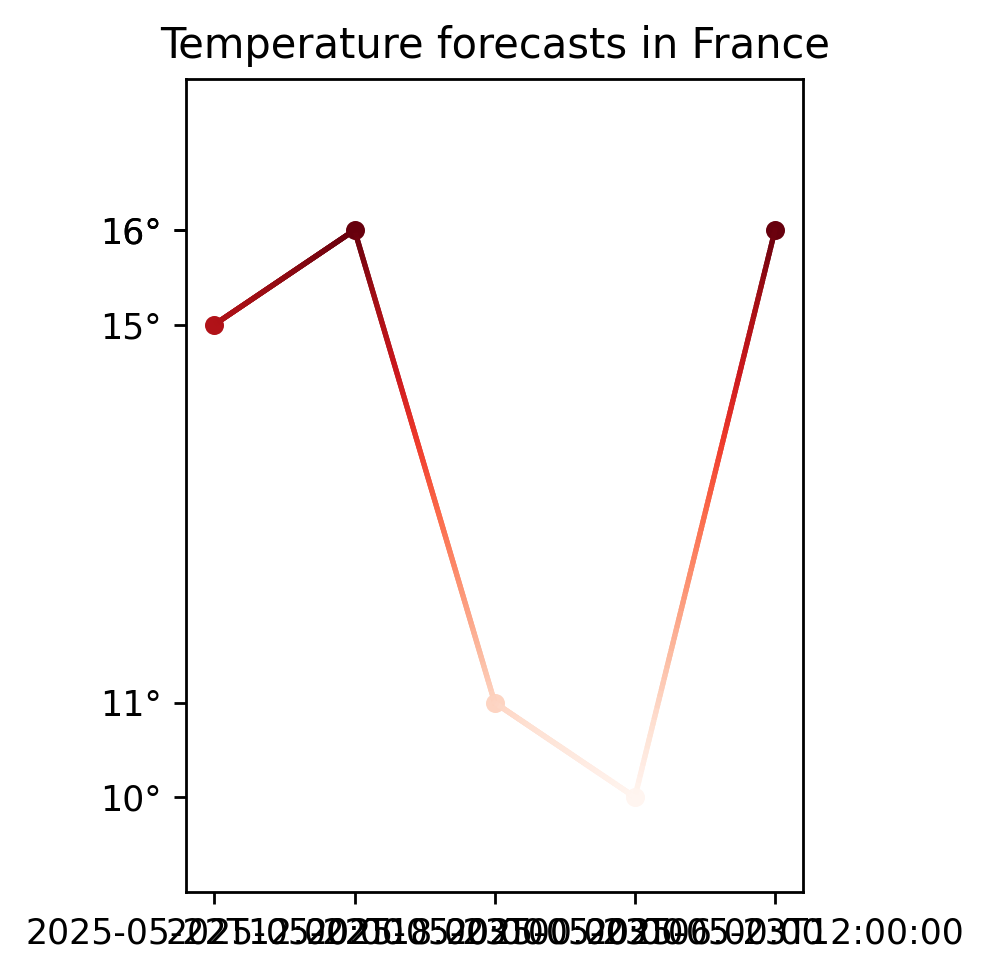

In [ ]:



#post_user_prompt ="Display the result on CairnFORM. Don't forget to include the result in your final answer. Format your final answer in Markdown."
post_user_prompt ="Display the result using the tool named 'cairnform_display_data'. Insert the resulting image in your final answer and format everything in Markdown."
# GUIDELINES
# 1. if the tool is not precise enough, add a few-shot example to the prompt
# 2. optimize tool to be as precise as possible (input parameters customization) to allow the LLM to get the data its needs (not less, not more).

# FRAMEWORK FOR DATA VIS FEATURES
# 1. plot
# 2. compare
# 3. filter
# 4. aggregate
# 5. sort
# 6. group
# 7. select
# 8. transform


# Miscellaneous Tasks
#user_input = "What time is it?"  # OK

## Live and forecast weather Tasks
# user_input = "What is the temperature in Paris right now?"  # OK
# user_input = "What is the humidity in Paris right now?"  # OK
# user_input = "What is the temperature in Bidart and in Bordeaux right now?"  # OK
# user_input = "How is the temperature, humidity, and wind in Bordeaux and Rennes right now?"  #  OK
# user_input = "How is the temperature in Bordeaux and Rennes tomorrow?"  #  OK
# user_input = "How is the temperature, humidity, and wind in Bordeaux and Rennes tomorrow?"  #  OK
# user_input = "What is the weather in France right now?"  # OK
#user_input = "What is the temperature in Paris in the next 5 days?"  # OK
user_input = "What is the temperature in France in the next 5 days?"  # ?
#user_input = "What is the weather in France in the next 5 days?"  # NOT OK

# Cryptocurrency Tasks
#user_input = "What is the price of Bitcoin and Ethereum right now?"  # OK


#user_input = "What is the wind speed in Bidart and Bordeaux?"  # (Ok for data fetch but not ok for CairnFORM)
#user_input = "What is the wind speed in Bidart and Bordeaux tomorrow?"  # (Ok for data fetch but not ok for CairnFORM)
user_prompt = f"{user_input}\n{post_user_prompt}"

# get context window size of the model
# context_window_size = llm.get_context_window_size()
# print("Context window size:", context_window_size)

# get the number of tokens in the prompt
ag = myAgent(llm, instructions, tools)
final_state = ag.invoke(user_prompt, verbose=True)
final_chat = ag.format_state_to_chat(final_state)
final_chat_messages = final_chat.to_messages()
for message in final_chat_messages:
    message.pretty_print()



In [ ]:
from IPython.display import display, Markdown
display(Markdown(final_state["output"]))

The temperature forecast for Paris over the next 5 days is as follows:

![Temperature Forecast in Paris](fig/7d4a163e-9157-4fee-89aa-57feae9af537.png)

In [ ]:
dataset = langfuse.get_dataset("Test")
 
for item in dataset.items:
    # Make sure your application function is decorated with @observe decorator to automatically link the trace
    with item.observe(
        run_name="first_run",
        run_description="My first run",
        run_metadata={"model": "mistral-small", "temperature": 0},
    ) as trace_id:
        # run your @observe() decorated application on the dataset item input
        #output = my_llm_application.run(item.input)
        agent_executor.invoke({"input": "What is the temperature in Bidart the day after tomorrow?", "chat_history": []}, config={"callbacks": [langfuse_handler]})
        # optionally, evaluate the output to compare different runs more easily
        langfuse.score(
            trace_id=trace_id,
            name="first_score",
            # any float value
            value= 1.0,#my_eval_fn(item.input, output, item.expected_output),
            comment="This is a comment",  # optional, useful to add reasoning
        )
 
# Flush the langfuse client to ensure all data is sent to the server at the end of the experiment run
langfuse.flush()

In [ ]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, List, Tuple, Any
set_verbose(True)
set_debug(False)

class AgentState(TypedDict):
    input: str
    chat_history: List[Tuple[str, str]]
    agent_scratchpad: List[Any]

builder = StateGraph(AgentState)

# Add steps (nodes)
builder.add_node("format_input", format_input_node)
builder.add_node("prompt", prompt_node)
builder.add_node("llm", llm_node)
builder.add_node("parse_output", output_parser_node)

# Connect the nodes
builder.set_entry_point("format_input")
builder.add_edge("format_input", "prompt")
builder.add_edge("prompt", "llm")
builder.add_edge("llm", "parse_output")
builder.set_finish_point("parse_output")

# Compile the graph
graph = builder.compile()

# Run it
result = graph.invoke({
    "input": "What is the current time?",
    "chat_history": [],
    "agent_scratchpad": []
})

In [ ]:
from langchain_ollama.chat_models import ChatOllama
llm = ChatOllama(model="mistral-small", temperature=0)
llm_with_tools = llm.bind_tools(tools)

In [ ]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage

sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search and performing Unit conversions on a set of inputs.")

def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

In [ ]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")
graph = builder.compile()

In [ ]:
from langchain_core.messages import HumanMessage
set_verbose(True)
set_debug(False)

messages = [
    HumanMessage(content="What is the current time? Display it on CairnFORM."),
]

result = graph.invoke({"messages": messages})

for msg in result["messages"]:
    msg.pretty_print()